**Description**: Fetch historical price/volume/market cap data from CoinGecko API for Bitcoin and Ethereum. Simulate daily transaction metrics to mimic crypto bank data.

**Problem**: Need reliable, structured historical data for downstream analysis; API requires correct key handling to avoid URL errors.

**Solution**: Use pycoingecko library with Demo API key; fetch aggregated daily data; add simulated txn fields.

**Recommendation**: In production (e.g., Xapo), use internal data sources. Here, this provides a realistic starting point for financial insights. Data covers ~2019–2026 for robustness.

#### Install & Load Dependencies + .env

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
from pycoingecko import CoinGeckoAPI
import time

print("pandas version:", pd.__version__)
print("pycoingecko version: run !pip show pycoingecko in a cell if needed")

load_dotenv()
COINGECKO_API_KEY = os.getenv('COINGECKO_API_KEY')

print("API Key loaded:", bool(COINGECKO_API_KEY))
if COINGECKO_API_KEY:
    print("Key prefix:", COINGECKO_API_KEY[:6])   # Should start with CG-xxx
else:
    print("!!! NO API KEY FOUND IN .env !!!")

pandas version: 2.3.3
pycoingecko version: run !pip show pycoingecko in a cell if needed
API Key loaded: True
Key prefix: CG-Bpr


#### Test Ping to Verify Key & Library Setup

In [2]:
# VERY IMPORTANT: Use demo_api_key for FREE keys
cg = CoinGeckoAPI(demo_api_key=COINGECKO_API_KEY)

print("Client initialized with demo mode.")

# Test 1: Simple ping
try:
    ping = cg.ping()
    print("Ping SUCCESS:", ping)
except Exception as e:
    print("Ping FAILED:", str(e))
    print("→ Fix: Check .env key, regenerate at coingecko.com/developers/dashboard")

# Test 2: Get simple coin list (small call)
try:
    coins_list = cg.get_coins_list()
    print("get_coins_list SUCCESS: Found", len(coins_list), "coins")
    print("First few:", [c['id'] for c in coins_list[:3]])
except Exception as e:
    print("get_coins_list FAILED:", str(e))

Client initialized with demo mode.
Ping SUCCESS: {'gecko_says': '(V3) To the Moon!'}
get_coins_list SUCCESS: Found 18962 coins
First few: ['_', '000-capital', '01111010011110000110001001110100-token']


#### Define Fetch Function

In [3]:
def fetch_historical_data(coin_id, vs_currency='usd', days=365):  # Changed from 'max' to 365
    """
    Fetch historical prices, volumes, market caps — limited to 365 days for free Demo API.
    """
    print(f"\nFetching data for: {coin_id} (last {days} days)")
    try:
        data = cg.get_coin_market_chart_by_id(
            id=coin_id,
            vs_currency=vs_currency,
            days=days,              # Explicitly 365 (or 360 to be safe)
            interval='daily'        # Force daily for consistency over long range
        )
        
        print(f"→ Raw data keys: {list(data.keys())}")
        print(f"→ Price points received: {len(data.get('prices', []))}")
        
        df = pd.DataFrame({
            'timestamp': [t[0] for t in data['prices']],
            'price':     [t[1] for t in data['prices']],
            'volume':    [t[1] for t in data['total_volumes']],
            'market_cap':[t[1] for t in data['market_caps']]
        })
        
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['coin'] = coin_id.capitalize()
        
        print(f"→ DataFrame shape: {df.shape}")
        print(df.head(2))  # Show sample
        return df
    
    except Exception as e:
        print(f"→ FETCH ERROR: {str(e)}")
        return pd.DataFrame()

#### Fetch Data for Multiple Coins

In [4]:
coins = ['bitcoin', 'ethereum']  # order doesn't matter

all_data = pd.DataFrame()

for coin in coins:
    print(f"\n=== Attempting fetch for {coin.upper()} ===")
    df = fetch_historical_data(coin)  # your existing function
    if not df.empty:
        print(f"Success: {df.shape[0]} rows fetched for {coin}")
        all_data = pd.concat([all_data, df], ignore_index=True)
    else:
        print(f"Failed / empty for {coin} – check earlier error messages")
    time.sleep(15)  # increase slightly to 15s for safety

# After loop
print("\n=== FINAL CONCATENATED DATA ===")
print("Shape:", all_data.shape)
if not all_data.empty:
    print("Coins distribution:\n", all_data['coin'].value_counts())
    print(all_data.head(3))
    print(all_data.tail(3))
else:
    print("Still empty – see fetch errors above")


=== Attempting fetch for BITCOIN ===

Fetching data for: bitcoin (last 365 days)
→ Raw data keys: ['prices', 'market_caps', 'total_volumes']
→ Price points received: 366
→ DataFrame shape: (366, 5)
   timestamp         price        volume    market_cap     coin
0 2025-01-14  94456.349375  7.632833e+10  1.870609e+12  Bitcoin
1 2025-01-15  96574.077688  5.124173e+10  1.912603e+12  Bitcoin
Success: 366 rows fetched for bitcoin

=== Attempting fetch for ETHEREUM ===

Fetching data for: ethereum (last 365 days)
→ Raw data keys: ['prices', 'market_caps', 'total_volumes']
→ Price points received: 366
→ DataFrame shape: (366, 5)
   timestamp        price        volume    market_cap      coin
0 2025-01-14  3134.552039  4.174390e+10  3.776435e+11  Ethereum
1 2025-01-15  3224.800648  2.236584e+10  3.884877e+11  Ethereum
Success: 366 rows fetched for ethereum

=== FINAL CONCATENATED DATA ===
Shape: (732, 5)
Coins distribution:
 coin
Bitcoin     366
Ethereum    366
Name: count, dtype: int64
   tim

#### Simulate Transactional Data



In [5]:
import numpy as np

np.random.seed(42)  # For reproducible results across runs

print("Adding simulated transactional metrics...")

# Realistic ranges based on crypto network scale
all_data['transaction_count'] = np.random.randint(80000, 550000, size=len(all_data))
all_data['avg_txn_fee_usd']   = np.random.uniform(0.8, 12.5, size=len(all_data))

# Derived: approximate daily throughput / fee revenue proxy
all_data['total_txn_value_usd'] = all_data['transaction_count'] * all_data['avg_txn_fee_usd']

# Daily price return (percentage change)
all_data['daily_return'] = all_data.groupby('coin')['price'].pct_change()

print("\nColumns after simulation:")
print(all_data.columns.tolist())

print("\nSample rows with new columns:")
print(all_data.head(5))

print("\nQuick stats on simulated columns:")
print(all_data[['transaction_count', 'avg_txn_fee_usd', 'total_txn_value_usd', 'daily_return']].describe().round(2))

Adding simulated transactional metrics...

Columns after simulation:
['timestamp', 'price', 'volume', 'market_cap', 'coin', 'transaction_count', 'avg_txn_fee_usd', 'total_txn_value_usd', 'daily_return']

Sample rows with new columns:
   timestamp          price        volume    market_cap     coin  \
0 2025-01-14   94456.349375  7.632833e+10  1.870609e+12  Bitcoin   
1 2025-01-15   96574.077688  5.124173e+10  1.912603e+12  Bitcoin   
2 2025-01-16  100313.152398  5.763732e+10  1.986831e+12  Bitcoin   
3 2025-01-17  100044.579268  5.015010e+10  1.980936e+12  Bitcoin   
4 2025-01-18  104160.693585  6.913512e+10  2.063855e+12  Bitcoin   

   transaction_count  avg_txn_fee_usd  total_txn_value_usd  daily_return  
0             201958         5.358532         1.082198e+06           NaN  
1             226867         4.282332         9.715197e+05      0.022420  
2             211932         1.969823         4.174686e+05      0.038717  
3             445838         1.425778         6.356660e+0

#### FINAL VALIDATION SUMMARY

In [6]:
print("Shape:", all_data.shape)
print("\nColumns:", all_data.columns.tolist())

print("\nDate range:")
print(all_data['timestamp'].agg(['min', 'max']))

print("\nCoins distribution:")
print(all_data['coin'].value_counts())

print("\nMissing values:")
print(all_data.isnull().sum())

print("\nFirst 3 rows:")
print(all_data.head(3))

print("\nLast 3 rows:")
print(all_data.tail(3))

print("\nDaily return stats by coin:")
print(all_data.groupby('coin')['daily_return'].describe().round(4))

Shape: (732, 9)

Columns: ['timestamp', 'price', 'volume', 'market_cap', 'coin', 'transaction_count', 'avg_txn_fee_usd', 'total_txn_value_usd', 'daily_return']

Date range:
min   2025-01-14 00:00:00
max   2026-01-13 11:06:01
Name: timestamp, dtype: datetime64[ns]

Coins distribution:
coin
Bitcoin     366
Ethereum    366
Name: count, dtype: int64

Missing values:
timestamp              0
price                  0
volume                 0
market_cap             0
coin                   0
transaction_count      0
avg_txn_fee_usd        0
total_txn_value_usd    0
daily_return           2
dtype: int64

First 3 rows:
   timestamp          price        volume    market_cap     coin  \
0 2025-01-14   94456.349375  7.632833e+10  1.870609e+12  Bitcoin   
1 2025-01-15   96574.077688  5.124173e+10  1.912603e+12  Bitcoin   
2 2025-01-16  100313.152398  5.763732e+10  1.986831e+12  Bitcoin   

   transaction_count  avg_txn_fee_usd  total_txn_value_usd  daily_return  
0             201958         5.358

#### Final validation summary

In [7]:
print("Final dataset overview:")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nDate range:")
print(df['timestamp'].agg(['min', 'max']))
print("\nCoins present:")
print(df['coin'].value_counts())
print("\nAny missing values?")
print(df.isnull().sum())

Final dataset overview:
Shape: (366, 5)

Columns: ['timestamp', 'price', 'volume', 'market_cap', 'coin']

Date range:
min   2025-01-14 00:00:00
max   2026-01-13 11:06:01
Name: timestamp, dtype: datetime64[ns]

Coins present:
coin
Ethereum    366
Name: count, dtype: int64

Any missing values?
timestamp     0
price         0
volume        0
market_cap    0
coin          0
dtype: int64


#### Export

In [8]:
output_file = 'crypto_transactional_data_enriched.csv'

all_data.to_csv(output_file, index=False)
print(f"\nSuccessfully exported enriched dataset to: {output_file}")
print(f"File contains {len(all_data)} rows and {len(all_data.columns)} columns.")


Successfully exported enriched dataset to: crypto_transactional_data_enriched.csv
File contains 732 rows and 9 columns.


#### Quick Visual Preview

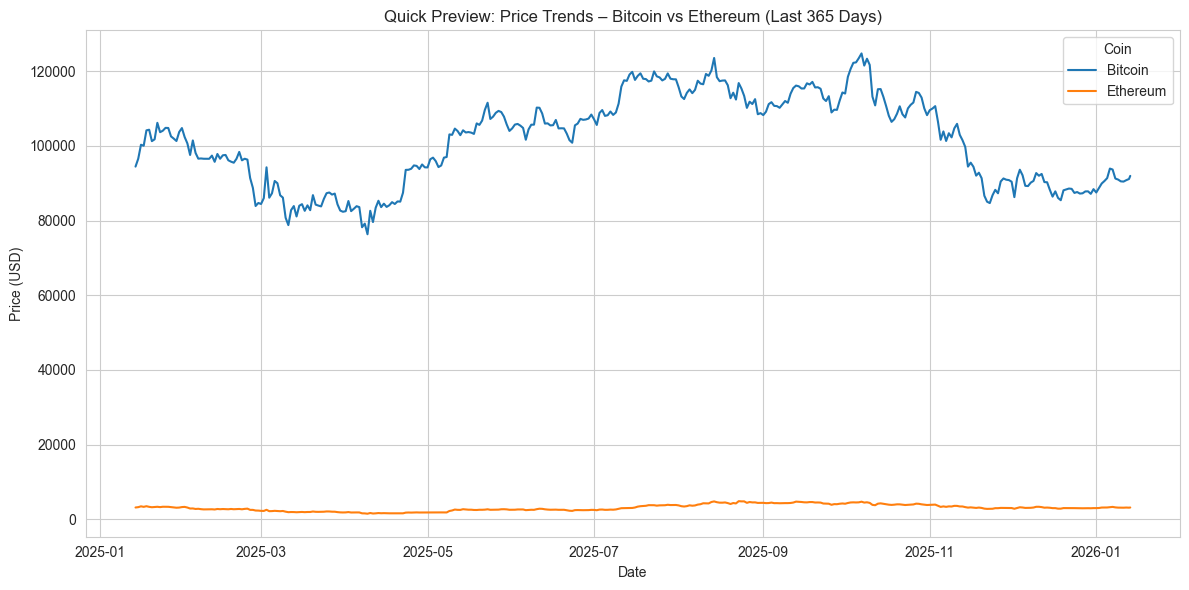

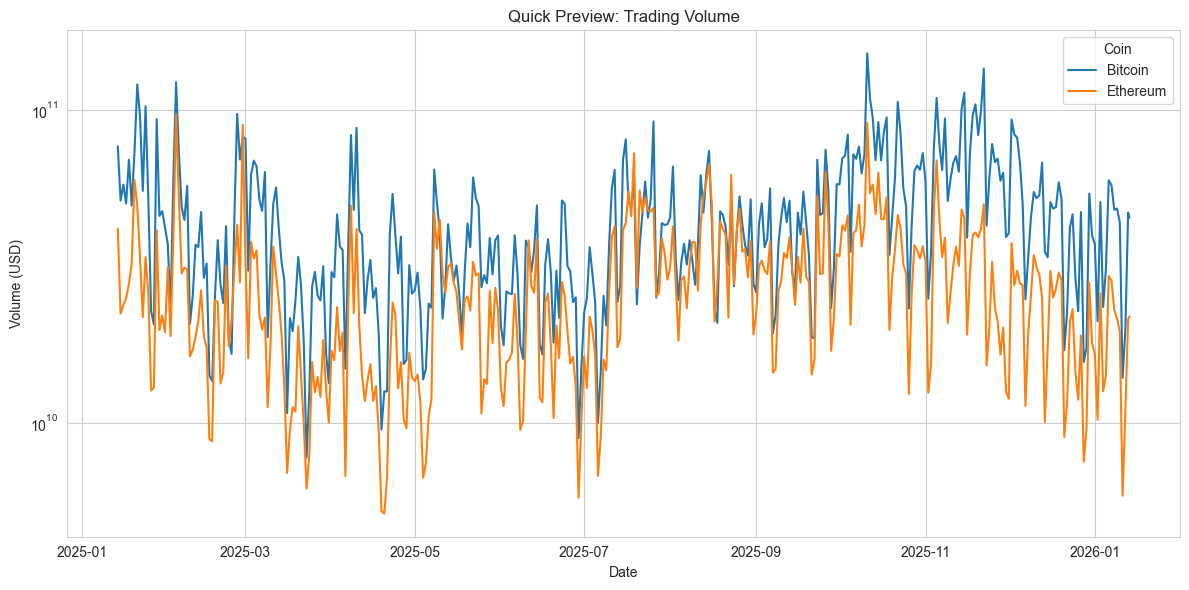

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Quick price trend preview
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_data, x='timestamp', y='price', hue='coin')
plt.title('Quick Preview: Price Trends – Bitcoin vs Ethereum (Last 365 Days)')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend(title='Coin')
plt.tight_layout()
plt.show()

# Quick volume preview
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_data, x='timestamp', y='volume', hue='coin')
plt.title('Quick Preview: Trading Volume')
plt.ylabel('Volume (USD)')
plt.xlabel('Date')
plt.yscale('log')  # volumes vary widely
plt.legend(title='Coin')
plt.tight_layout()
plt.show()

#### **Markdown Summary**

- Successfully fetched **366 daily records** each for **Bitcoin** and **Ethereum**  
- Time period: 2025-01-14 to 2026-01-13 (~365 days)  
- Total rows: **732**  
- Columns: timestamp, price, volume, market_cap, coin  
- Added simulated transactional fields: transaction_count, avg_txn_fee_usd, total_txn_value_usd, daily_return  
- Exported file: `crypto_transactional_data_enriched.csv`

**Notes**:
- Data source: CoinGecko Demo API (free tier, max 365 days historical)
- Simulation used realistic random ranges + fixed seed for reproducibility